# Lab 5-1: Multiple Linear Regression
---

We are going to try and improve upon our simple linear regression model from Lab 4-1 with the snow water equivalent (SWE) data (if you're interested, [read about SWE and snow pillows here](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/null/?cid=nrcseprd1314833)). In Lab 4-1 we used SWE observations from Slide Canyon to predict SWE at Blue Canyon. In this lab we will use two explanatory variables, SWE at Slide Canyon and time, to try and predict SWE at Blue Canyon. We can also compare both of these to the quantile regression model from Lab 4-2.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.linalg import lstsq # for the multiple linear regression, we'll use the scipy linear algebra least-squares function
from scipy.interpolate import interp1d # for quantile regression, we'll want this 1d interpolation function
import matplotlib.pyplot as plt
%matplotlib inline

Load the csv file with snow water equivalent (SWE) measurements from two sites in California's Sierra Nevada. 

In [2]:
# Read in a .csv file
data = pd.read_csv('../data/pillows_example.csv')
data.head()

,years,BLC_max,SLI_max
0,1983,688,2446
1,1984,112,1471
2,1985,216,1143
3,1986,150,1085
4,1987,94,569


These data are annual maximum SWE values (mm) for the Blue Canyon (BLC), and Slide Canyon (SLI) measurement sites.

Plot the original SWE data for both sites.

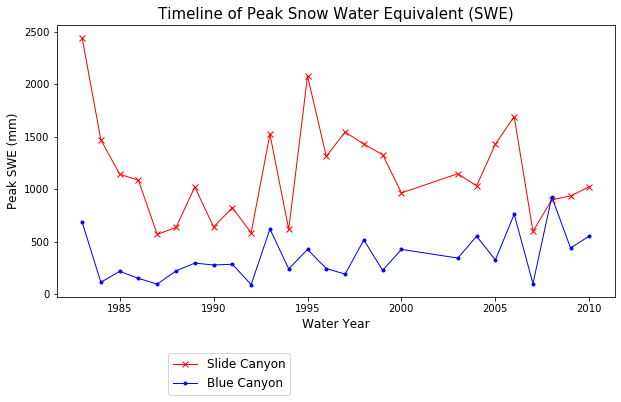

In [3]:
fig, ax = plt.subplots(figsize=(10,5))

data.plot(x='years', y='SLI_max', c='r', linestyle='-', linewidth=1, marker='x', ax=ax, label='Slide Canyon')
data.plot(x='years', y='BLC_max', c='b', linestyle='-', linewidth=1, marker='.', ax=ax, label='Blue Canyon')

ax.set_title('Timeline of Peak Snow Water Equivalent (SWE)', fontsize=15)
ax.set_xlabel('Water Year', fontsize=12)
ax.set_ylabel('Peak SWE (mm)', fontsize=12);
plt.legend(loc=(0.2,-0.36), fontsize=12);

**What does the above plot show?** What you see above is a plot of the maximum value of snow water equivalent (SWE) measured at two snow pillows (these weigh the snow and convert that weight into the water content of the snow). These measurements of snow are not too far from each other geographically (both in the Sierra Nevada, California, although Slide Canyon is at a higher elevation and further south), and we might expect that more snow at one site woud correspond to more snow at the other site as well. We can check this by examining a regression between the data at the two sites.

---
## **Simple Linear Regression**

We'll start off by replicating our simple linear regression model from Lab 4-1. The first step to any regression or correlation analysis is to create a scatter plot of the data.

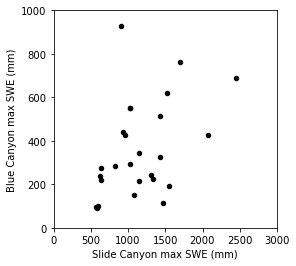

In [4]:
fig, ax = plt.subplots(figsize=(4,4))

# Scatterplot
data.plot.scatter(x='SLI_max', y='BLC_max', c='k', ax=ax);

ax.set_xlabel('Slide Canyon max SWE (mm)')
ax.set_ylabel('Blue Canyon max SWE (mm)');

ax.set_xlim((0,3000))
ax.set_ylim((0,1000));

**Linear regression**: Could we use SWE measurements at Slide Canyon to predict SWE at Blue Canyon?

The plot above suggests that this is a borderline case for applying linear regression analysis. What rules of linear regression might we worry about here? ([*heteroscedasticity*](https://en.wikipedia.org/wiki/Heteroscedasticity))

We will proceed with calculating the regression and then look at the residuals to get a better idea of whether this is the best approach.

Here we're using the [`scipy.stats.linregress()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) function to create a least-squares linear regression model.

In [5]:
# use the linear regression function
B1, B0, rvalue, pvalue, sB1 = stats.linregress(data.SLI_max, data.BLC_max)

Plot the result.

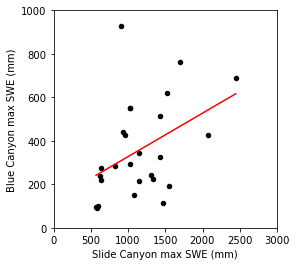

In [6]:
fig, ax = plt.subplots(figsize=(4,4))

# Scatterplot
data.plot.scatter(x='SLI_max', y='BLC_max', c='k', ax=ax);

# Create points for the regression line
x = np.linspace(data.SLI_max.min(), data.SLI_max.max(), data.SLI_max.size) # x coordinates from min and max values of SLI_max
y = B1 * x + B0 # y coordinates using the slope and intercept from our linear regression

# Plot the regression line
ax.plot(x, y, '-r')

ax.set_xlabel('Slide Canyon max SWE (mm)')
ax.set_ylabel('Blue Canyon max SWE (mm)');

ax.set_xlim((0,3000))
ax.set_ylim((0,1000));

Print out our linear regression parameter (slope and intercept), our correlation coefficient, standard error of the gradient. Then compute the standard error of the regression from the standard error of the gradient:

In [7]:
print('B0 : {}'.format(np.round(B0,4)))
print('B1 : {}'.format(np.round(B1,4)))
print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr of the gradient: {}'.format(np.round(sB1,3)))

# Compute the SST for x
sst_x = np.sum( (x - np.mean(x))**2 )

# Compute the standard error
stderr = sB1 * np.sqrt(sst_x)
print('stderr of the regression : {}'.format(np.round(stderr,3)))

B0 : 127.9143
B1 : 0.1997
R^2 : 0.181
R : 0.425
stderr of the gradient: 0.087
stderr of the regression : 249.316


**Plot residuals**

We should make a plot of the residuals (actual - predicted values). For a good linear fit, we hope that our residuals are small, don't have any trends or patterns themselves, want them to be normally distributed:

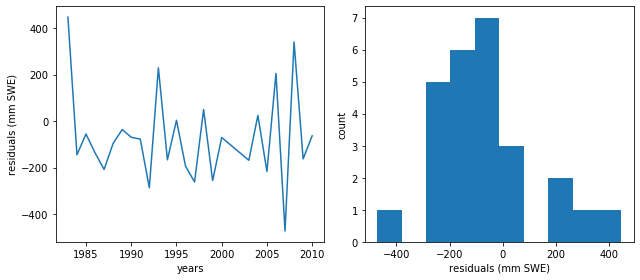

In [8]:
residuals = data.BLC_max - y

f, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4))

ax1.plot(data.years,residuals)
ax1.set_xlabel('years')
ax1.set_ylabel('residuals (mm SWE)')

ax2.hist(residuals)
ax2.set_xlabel('residuals (mm SWE)')
ax2.set_ylabel('count')

f.tight_layout()

Ideally our residuals should be "random" and normally distributed.

**Finally, make predictions with our linear model**

Let's plot what the predictions of Blue Canyon SWE would look like if we were to use this linear model:

In [9]:
# Use our linear model to make predictions:
BLC_linear_model = B1 * data.SLI_max + B0

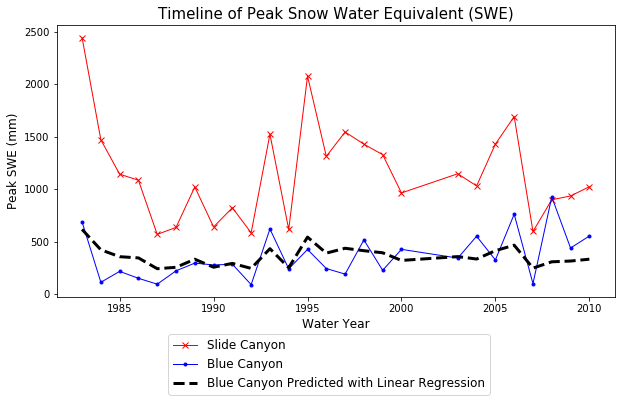

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

data.plot(x='years', y='SLI_max', c='r', linestyle='-', linewidth=1, marker='x', ax=ax, label='Slide Canyon')
data.plot(x='years', y='BLC_max', c='b', linestyle='-', linewidth=1, marker='.', ax=ax, label='Blue Canyon')

# Plot the predicted SWE at Blue Canyon
ax.plot(data.years, BLC_linear_model, c='k', linestyle='--', linewidth=3, label='Blue Canyon Predicted with Linear Regression')

ax.set_title('Timeline of Peak Snow Water Equivalent (SWE)', fontsize=15)
ax.set_xlabel('Water Year', fontsize=12)
ax.set_ylabel('Peak SWE (mm)', fontsize=12);
plt.legend(loc=(0.2,-0.36), fontsize=12);

**Is the slope of our linear regression significantly different from zero?** In Lab 4-3 we performed a hypothesis test on the slope of a linear regression to test the null hypothesis that the slope is zero. We can repeat that here too.

In [11]:
# null hypothesis B1 = 0
nullB1 = 0
# our alpha for 95% confidence
alpha = 0.05
# length of the dataset
n = len(x)
# degrees of freedom
dof = n - 2
# find our critical t values for a two-tailed t-distribution (t-value for alpha/2 with n-2 degrees of freedom)
t_critical = stats.t.ppf(1-alpha/2, dof)
print('t_critical = {}'.format(t_critical))
# compute the t-test statistic
t_test = (B1 - nullB1) / sB1
print('t_test = {}'.format(t_test))


t_critical = 2.0638985616280205
t_test = 2.299628418171643


t-test > t-critical (at 95% confidence), therefore we can reject the null hypothesis and say that the slope is non-zero.

---
## **Multiple Linear Regression**

Now we are going to use both Slide Canyon SWE and time to try and predict Blue Canyon SWE.

Start off by making scatter plots of our two independent variables (Slide Canyon SWE, time) and the dependent variable (Blue Canyon SWE).

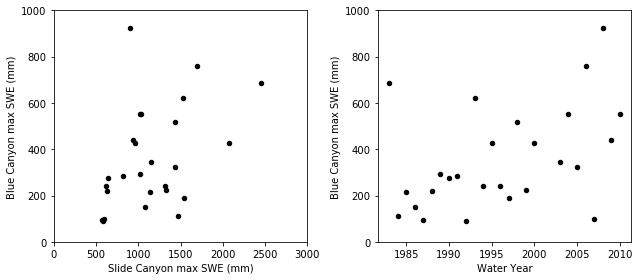

In [12]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(9,4), tight_layout=True)

# Scatterplot of SLI and BLC SWE
data.plot.scatter(x='SLI_max', y='BLC_max', c='k', ax=ax1);
ax1.set_xlabel('Slide Canyon max SWE (mm)')
ax1.set_ylabel('Blue Canyon max SWE (mm)');
ax1.set_xlim((0,3000))
ax1.set_ylim((0,1000));

# Scatterplot of Time and BLC SWE
data.plot.scatter(x='years', y='BLC_max', c='k', ax=ax2);
ax2.set_xlabel('Water Year')
ax2.set_ylabel('Blue Canyon max SWE (mm)');
ax2.set_ylim((0,1000));

We can also use a function like the [scatterplot matrix](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.scatter_matrix.html) in pandas to plot each variable against each other variable (such as for visualizing correlation between all our variables). By default it's not the best looking plot, but there are plenty of options in the documentation to improve the appearance.

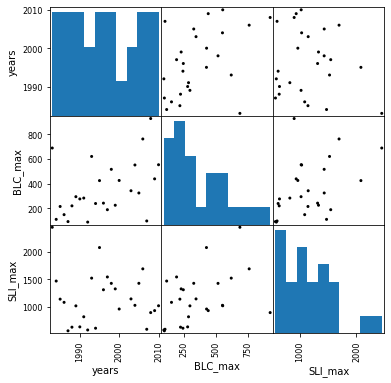

In [13]:
pd.plotting.scatter_matrix(data, figsize=(6,6), color='k', marker='.', alpha=1);

For the multiple linear regression, we'll use the scipy linear algebra least-squares function, [`scipy.linalg.lstsq()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html#scipy.linalg.lstsq).

In [14]:
# check out the function's documentation
#lstsq?

Note that the [documentation for this function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html#scipy.linalg.lstsq) states that it requires input of an array that includes vectors of all of the predictor variables we are considering.

Below, we create an array made up of the maximum annual SWE at Slide Canyon and the year. We also need an array of ones (which allows for a constant term, the intercept, in the regression).

In [15]:
years_array = np.linspace(1,data.years.size,data.years.size)

# create the input array
multi_input = np.array([ 
                         data.SLI_max, # SWE at slide canyon
                         years_array, # instead of the actual year numbers, just use a count of years starting at 1
                         np.ones_like(data.years) # array of ones so we allow a constant, y-intercept, value
                       ]).T # Transform this array with ".T" to swap rows and columns

# Show the shapes of our two inputs to the lstsq function to make sure they have the same first dimension length
print(multi_input.shape)
print(data.BLC_max.shape)

(26, 3)
(26,)


Now use the lstsq function and print the resulting regression parameters.

In [16]:
B, _, _, _ = lstsq(multi_input, data.BLC_max) # I'm using "_" as a placeholder for the outputs I don't need
print(B)

[  0.22156219  13.77959269 -83.33208798]


The values of B, above, show the coefficients we would assing to the Slide Canyon SWE (B[0]), the year (B[1]), and the constant offset (B[2]), in the order shown.

**Make predictions with our linear model**

Here we're using the [`.dot()`](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) method to take the dot product between our input array and output regression coefficients.

In [17]:
# Use our linear model to make predictions:
BLC_multiple_linear_model = multi_input.dot(B)

# We could also do it this way:
#BLC_multiple_linear_model = B[0]*data.SLI_max + B[1]*years_array + B[2]

**Plot residuals**

We should make a plot of the residuals (actual - predicted values). For a good linear fit, we hope that our residuals are small, don't have any trends or patterns themselves, want them to be normally distributed.

How do these compare to the residuals of the simple linear regression model?

Generally, adding more predictors will always decrease the residual error in the region where the model is developed but may increase the error in a region outside of when it was developed. (To test this, it's best practice to keep some data separate from the regression model development and then test model performance there. You could take a subset of the data above, recalcuate the regression coefficients and then check your model prediction vs. observed for years outside of your original dataset to see if the mulitple regression actually improves your predictive capabilities.)

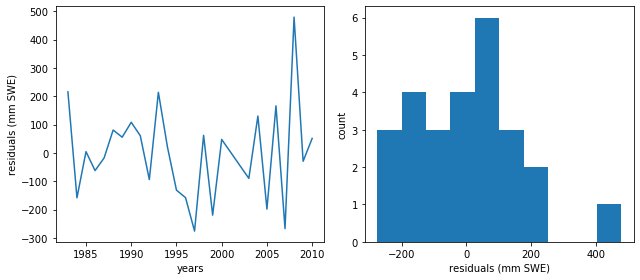

In [18]:
ml_residuals = data.BLC_max - BLC_multiple_linear_model

f, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4))

ax1.plot(data.years,ml_residuals)
ax1.set_xlabel('years')
ax1.set_ylabel('residuals (mm SWE)')

ax2.hist(ml_residuals)
ax2.set_xlabel('residuals (mm SWE)')
ax2.set_ylabel('count')

f.tight_layout()

**Now compare our simple regression model with our multi-regression model.** 

Plot the results from the two different regression methods. How and where are they different?

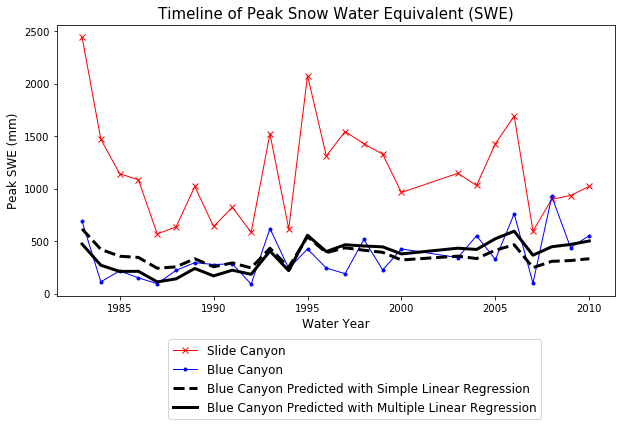

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

# Original data
data.plot(x='years', y='SLI_max', c='r', linestyle='-', linewidth=1, marker='x', ax=ax, label='Slide Canyon')
data.plot(x='years', y='BLC_max', c='b', linestyle='-', linewidth=1, marker='.', ax=ax, label='Blue Canyon')

# Plot the predicted SWE at Blue Canyon from the simple linear regression model
ax.plot(data.years, BLC_linear_model, c='k', linestyle='--', linewidth=3, label='Blue Canyon Predicted with Simple Linear Regression')

# Plot the predicted SWE at Blue Canyon from the multiple linear regression model
ax.plot(data.years, BLC_multiple_linear_model, c='k', linestyle='-', linewidth=3, label='Blue Canyon Predicted with Multiple Linear Regression')

ax.set_title('Timeline of Peak Snow Water Equivalent (SWE)', fontsize=15)
ax.set_xlabel('Water Year', fontsize=12)
ax.set_ylabel('Peak SWE (mm)', fontsize=12);
plt.legend(loc=(0.2,-0.45), fontsize=12);

---

## **Quantile Regression**

For completeness, we can also perform a quantile regression like in Lab 4-2, then compare all three types of regression models.

Create empirical CDFs for both SWE data sets

In [20]:
quantiles = np.linspace(0,1,100)

# This is our empirical cdf of the Slide Canyon data, which also includes values down to 0 and up to 1.
SLI_ordered = stats.mstats.mquantiles(data.SLI_max, quantiles)

# This is our empirical cdf of the Blue Canyon data, which also includes values down to 0 and up to 1.
BLC_ordered = stats.mstats.mquantiles(data.BLC_max, quantiles)

Use the CDFs to "look up" SWE from Slide Canyon to predict SWE in Blue Canyon

In [21]:
# Create our interpolation function for looking up a quantile given a value of SWE at Slide Canyon
f_SLI = interp1d(SLI_ordered, quantiles)
# Create our interpolation function for looking up SWE at Blue Canyon given a quantile
g_BLC = interp1d(quantiles, BLC_ordered)

# Now, we can create a prediction for every value in the Slide Canyon dataset to come up with a matching prediction for the Blue Canyon dataset
BLC_predicted=g_BLC( f_SLI( data.SLI_max ) )

**Plot the results from all three regression models together**

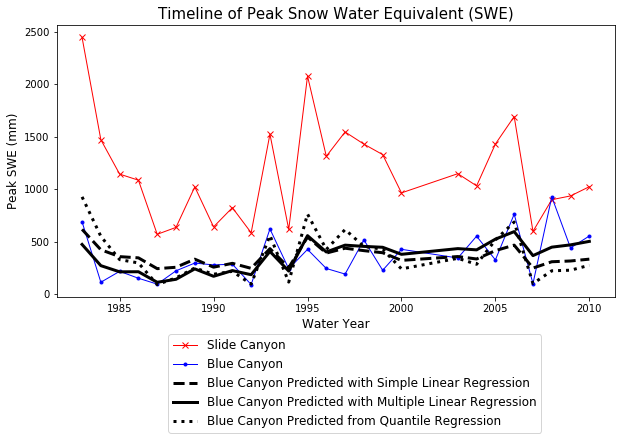

In [22]:
fig, ax = plt.subplots(figsize=(10,5))

# Original data
data.plot(x='years', y='SLI_max', c='r', linestyle='-', linewidth=1, marker='x', ax=ax, label='Slide Canyon')
data.plot(x='years', y='BLC_max', c='b', linestyle='-', linewidth=1, marker='.', ax=ax, label='Blue Canyon')

# Plot the predicted SWE at Blue Canyon from the simple linear regression model
ax.plot(data.years, BLC_linear_model, c='k', linestyle='--', linewidth=3, label='Blue Canyon Predicted with Simple Linear Regression')

# Plot the predicted SWE at Blue Canyon from the multiple linear regression model
ax.plot(data.years, BLC_multiple_linear_model, c='k', linestyle='-', linewidth=3, label='Blue Canyon Predicted with Multiple Linear Regression')

# Predicted with linear regression between Slide Canyon and Blue Canyon
plt.plot(data.years,BLC_predicted, c='k', linestyle=':', linewidth=3, label='Blue Canyon Predicted from Quantile Regression')

ax.set_title('Timeline of Peak Snow Water Equivalent (SWE)', fontsize=15)
ax.set_xlabel('Water Year', fontsize=12)
ax.set_ylabel('Peak SWE (mm)', fontsize=12);
plt.legend(loc=(0.2,-0.5), fontsize=12);